# International Movie Database (IMDb)
---

IMDb is an online database of information related to films, television series, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews. IMDb began as a fan-operated movie database on the Usenet group "rec.arts.movies" in 1990, and moved to the Web in 1993. It is now owned and operated by IMDb.com, Inc., a subsidiary of Amazon

![](https://static.amazon.jobs/teams/53/thumbnails/IMDb_Jobs_Header_Mobile.jpg?1501027253)

In [165]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will be predicting movie ratings with the help of data being collected from IMDb and Kaggle

#Importing required libraries

In [166]:
# importing libraries

import lxml
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from requests import get 
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

# Web Scraping

In [167]:
# List of URLs
url1 = []
pages = np.arange(1,10000,100)
for i in pages:
  url1.append("https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start=" + str(i)+"&ref_=adv_nxt")
  
# creating a web scraping function
class IMDB(object):
 
  def __init__(self, url):
    super(IMDB, self).__init__()
    page = get(url)

    self.soup = BeautifulSoup(page.content, 'lxml')


  def articleTitle(self):
    return self.soup.find("h1", class_="header").text.replace("\n","")

  def bodyContent(self):
    content = self.soup.find(id="main")
    return content.find_all("div",class_="lister-item mode-advanced")

  def movieData(self):
    movieFrame = self.bodyContent()
    movieTitle = []
    movieDate = []
    movieRunTime = []
    movieGenre = []
    movieRating = []
    movieScore = []
    movieDescription = []
    movieDirector = []
    movieStars = []
    movieVotes = []
    movieGross = []
    movieMetascore1 = []
    movieMetascore2 = []
    movieMetascore3 = []
    for movie in movieFrame:
      movieFirstLine = movie.find("h3", class_="lister-item-header")
      movieTitle.append(movieFirstLine.find("a").text)
      movieDate.append(re.sub(r"[()]","", movieFirstLine.find_all("span")[-1].text))
      try:
        movieRunTime.append(movie.find("span", class_="runtime").text[:-4])
      except: 
        movieRunTime.append(np.nan)

      try:
        movieRating.append(movie.find("strong").text)
      except:
        movieRating.append(np.nan)
      
      try:
        movieScore.append(movie.find("span",class_="metascore unfavourable").text.rstrip())
      except:
        movieScore.append(np.nan)
      
      movieDescription.append(movie.find_all("p",class_="text-muted")[-1].text.lstrip())
      movieCast = movie.find("p",class_="")

      try:
        casts = movieCast.text.replace("\n","").split('|')
        casts = [x.strip() for x in casts]
        casts = [casts[i].replace(j, "") for i,j in enumerate(["Director:", "Stars"])]
        movieDirector.append(casts[0])
        movieStars.append([x.strip() for x in casts[1].split(",")])

      except:
        casts = movieCast.text.replace("\n","").strip()
        movieDirector.append(np.nan)
        movieStars.append([x.strip() for x in casts.split(",")])

      movieNumbers = movie.find_all("span", attrs = {"name": "nv"})
      if len(movieNumbers) == 2:
        movieVotes.append(movieNumbers[0].text)
        movieGross.append(movieNumbers[1].text)
      elif len(movieNumbers) == 1:
        movieVotes.append(movieNumbers[0].text)
        movieGross.append(np.nan)
      else:
        movieVotes.append(np.nan)
        movieGross.append(np.nan)

      movieNumbers2 = movie.find_all("span", class_="metascore unfavourable")

      if len(movieNumbers2) == 1:
        movieMetascore1.append(movieNumbers2[0].text)
      else:
        movieMetascore1.append(np.nan)

      movieNumbers3 = movie.find_all("span", class_="metascore favourable")

      if len(movieNumbers3) == 1:
        movieMetascore2.append(movieNumbers3[0].text)
      else:
        movieMetascore2.append(np.nan)

      movieNumbers4 = movie.find_all("span", class_="metascore mixed")

      if len(movieNumbers4) == 1:
        movieMetascore3.append(movieNumbers4[0].text)
      else:
        movieMetascore3.append(np.nan)

    movieData = [movieTitle, movieDate, movieRunTime, movieRating, movieScore, movieDescription, movieDirector, movieStars, movieVotes,
               movieGross, movieMetascore1, movieMetascore2, movieMetascore3]
    return movieData

# Apply IMDB function on list of URLs and store data in them
data = []
for i in range(40):
  if __name__ == '__main__':
    site1=IMDB(url1[i])
    print("Subject: ",site1.articleTitle())
    data.append(site1.movieData())

Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  Feature Film/TV Series(Sorted by Popularity Ascending) 
Subject:  

# Data Preprocessing

In [168]:
# Appending data

for i in range(len(data)):
  data[i]=pd.DataFrame(data[i]).transpose()

df = data[0].append([data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9], data[10],
                     data[11], data[12], data[13], data[14], data[15], data[16], data[17], data[18], data[19], data[20],
                     data[21], data[22], data[23], data[24], data[25], data[26], data[27], data[28], data[29], data[30],
                     data[31], data[32], data[33], data[34], data[35], data[36], data[37], data[38], data[39]])

In [169]:
# Renaming the year column

df_new = df.rename(columns={1: 'year'})
df_new.head()

,0,year,2,3,4,5,6,7,8,9,10,11,12
0,Stranger Things,2016–,51,8.7,NaN,"When a young boy disappears, his mother, a pol...",TV-14,[51 min],"1,009,805",NaN,NaN,NaN,NaN
1,Top Gun: Maverick,2022,131,8.7,NaN,After more than thirty years of service as one...,PG-13,[131 min],"70,363",NaN,NaN,NaN,NaN
2,Better Call Saul,2015–2022,46,8.8,NaN,The trials and tribulations of criminal lawyer...,TV-MA,[46 min],"415,053",NaN,NaN,NaN,NaN
3,"Love, Death & Robots",2019–,15,8.4,NaN,A collection of animated short stories that sp...,TV-MA,[15 min],"144,451",NaN,NaN,NaN,NaN
4,Top Gun,1986,110,6.9,NaN,As students at the United States Navy's elite ...,PG,[110 min],"350,289",$179.80M,NaN,NaN,50


In [170]:
# Creating a column for metascore

df_new['meta'] = np.nan

In [171]:
# Assigning value to metascore column

for i in range(len(df_new)):
  if (pd.notnull(df_new.iloc[i,10])):
    df_new.iloc[i,13]=df_new.iloc[i,10]
  elif (pd.notnull(df_new.iloc[i,11])):
    df_new.iloc[i,13] = df_new.iloc[i,11]
  else:
    df_new.iloc[i,13] = df_new.iloc[i,12]

In [172]:
df_new.head()

,0,year,2,3,4,5,6,7,8,9,10,11,12,meta
0,Stranger Things,2016–,51,8.7,NaN,"When a young boy disappears, his mother, a pol...",TV-14,[51 min],"1,009,805",NaN,NaN,NaN,NaN,NaN
1,Top Gun: Maverick,2022,131,8.7,NaN,After more than thirty years of service as one...,PG-13,[131 min],"70,363",NaN,NaN,NaN,NaN,NaN
2,Better Call Saul,2015–2022,46,8.8,NaN,The trials and tribulations of criminal lawyer...,TV-MA,[46 min],"415,053",NaN,NaN,NaN,NaN,NaN
3,"Love, Death & Robots",2019–,15,8.4,NaN,A collection of animated short stories that sp...,TV-MA,[15 min],"144,451",NaN,NaN,NaN,NaN,NaN
4,Top Gun,1986,110,6.9,NaN,As students at the United States Navy's elite ...,PG,[110 min],"350,289",$179.80M,NaN,NaN,50,50


In [173]:
# Dropping metascore columns

movies_df = df_new.drop(columns=[4,10,11,12], axis=1)

In [174]:
# Renaming columns

movies_df.columns = ['title', 'year', 'duration', 'rating', 'description', 'director', 'actors', 'votes', 'budget', 'metascore']

In [175]:
# Subletting the data to movies subset

movies = movies_df[~movies_df['year'].str.contains('-')]
movies.head()

,title,year,duration,rating,description,director,actors,votes,budget,metascore
0,Stranger Things,2016–,51,8.7,"When a young boy disappears, his mother, a pol...",TV-14,[51 min],"1,009,805",NaN,NaN
1,Top Gun: Maverick,2022,131,8.7,After more than thirty years of service as one...,PG-13,[131 min],"70,363",NaN,NaN
2,Better Call Saul,2015–2022,46,8.8,The trials and tribulations of criminal lawyer...,TV-MA,[46 min],"415,053",NaN,NaN
3,"Love, Death & Robots",2019–,15,8.4,A collection of animated short stories that sp...,TV-MA,[15 min],"144,451",NaN,NaN
4,Top Gun,1986,110,6.9,As students at the United States Navy's elite ...,PG,[110 min],"350,289",$179.80M,50


In [176]:
# Getting last 4 numbers of year
for i in range(len(movies)):
  movies.iloc[i,1]=movies.iloc[i,1][-4:]

# Importing 2nd dataset

In [177]:
movies_kaggle = pd.read_csv('/content/drive/MyDrive/Python Projects/movies_metadata.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [178]:
movies_kaggle.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [179]:
movies_kaggle.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [180]:
# Dropping columns that will not be used

movies_kaggle = movies_kaggle.drop(columns=['belongs_to_collection', 'budget', 'homepage', 'id', 'imdb_id',
                                            'original_title', 'overview', 'runtime', 'spoken_languages',
                                            'status', 'tagline', 'video',
                                            'vote_average', 'vote_count'], axis = 1)

In [181]:
# Removing duplicates from the title column

movies_kaggle=movies_kaggle.drop_duplicates(subset='title', keep=False)

In [182]:
# Getting last 4 numbers of year

for i in range(len(movies_kaggle)):
  if (pd.notnull(movies_kaggle.iloc[i,7])):
    movies_kaggle.iloc[i,7]=movies_kaggle.iloc[i,7][0:4]

In [183]:
# Joining the two dataframes

movies_ratings = pd.merge(movies, movies_kaggle, left_on=['title', 'year'], right_on=['title', 'release_date'])

In [184]:
len(movies_ratings)

1491

In [185]:
movies_ratings.columns

Index(['title', 'year', 'duration', 'rating', 'description', 'director',
       'actors', 'votes', 'budget', 'metascore', 'adult', 'genres',
       'original_language', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue'],
      dtype='object')

In [186]:
movies_ratings = movies_ratings.drop(columns='release_date', axis=1)

In [187]:
# Checking for null values

movies_ratings.isnull().sum()

title                     0
year                      0
duration                  0
rating                    0
description               0
director                  0
actors                    0
votes                     0
budget                   69
metascore               987
adult                     0
genres                    0
original_language         0
popularity                0
poster_path               0
production_companies      0
production_countries      0
revenue                   0
dtype: int64

In [188]:
movies_ratings['duration'] = movies_ratings['duration'].astype(str).astype(float)
movies_ratings['rating'] = movies_ratings['rating'].astype(str).astype(float)
movies_ratings['metascore'] = movies_ratings['metascore'].astype(str).astype(float)
movies_ratings['popularity'] = movies_ratings['popularity'].astype(str).astype(float)
movies_ratings['revenue'] = movies_ratings['revenue'].astype(str).astype(float)

In [189]:
# Cleaning the budget column

for i in range(len(movies_ratings)):
  if(pd.notnull(movies_ratings.iloc[i,8])):
    movies_ratings.iloc[i,8]=movies_ratings.iloc[i,8].strip('$').strip('M')

In [190]:
movies_ratings['budget'] = movies_ratings['budget'].astype(str).astype(float)

In [191]:
movies_ratings['budget']=movies_ratings['budget']*1000000

In [192]:
movies_ratings['title']=movies_ratings['title'].astype('str')
movies_ratings['year']=movies_ratings['year'].astype('str').astype('category')
movies_ratings['director']=movies_ratings['director'].astype('str').astype('category')
movies_ratings['adult']=movies_ratings['adult'].astype('str').astype('category')
movies_ratings['original_language']=movies_ratings['original_language'].astype('str').astype('category')

In [193]:
# Dropping null values

movies_ratings = movies_ratings.dropna(how='any', axis=0)

# Exploratory Data Analysis

In [194]:
movies_ratings.describe()

,duration,rating,budget,metascore,popularity,revenue
count,496.000000,496.000000,4.960000e+02,496.000000,496.000000,4.960000e+02
mean,113.629032,6.577016,8.536762e+07,50.790323,13.690211,1.934108e+08
std,18.297747,0.655201,8.027488e+07,5.873789,25.089837,2.210584e+08
min,81.000000,3.400000,2.000000e+04,40.000000,0.393865,0.000000e+00
25%,100.000000,6.200000,3.154250e+07,46.000000,8.576823,4.390872e+07
50%,110.000000,6.600000,6.115500e+07,51.000000,11.073994,1.229171e+08
75%,125.000000,7.000000,1.170825e+08,56.000000,14.417171,2.589993e+08
max,191.000000,8.600000,6.522700e+08,60.000000,547.488298,1.513529e+09


## Plot 1: Correlation Matrix

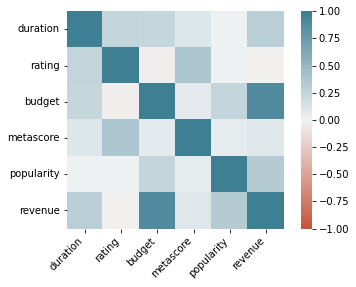

In [195]:
# Correlation Matrix

corr = movies_ratings.corr()
ax = sns.heatmap(corr,
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True);
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right');

## Plot 2: Boxplot of Variables


### Variable: Duration

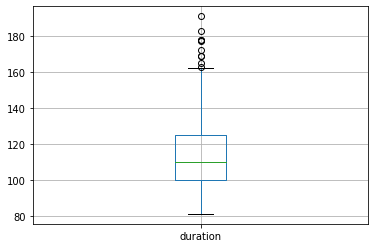

In [196]:
movies_ratings.boxplot(column=['duration'])

### Variable: Rating

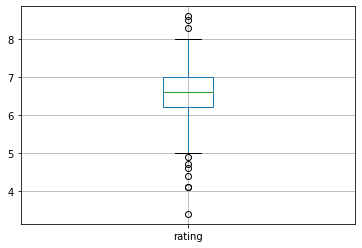

In [197]:
movies_ratings.boxplot(column=['rating'])

### Varibale: Budget

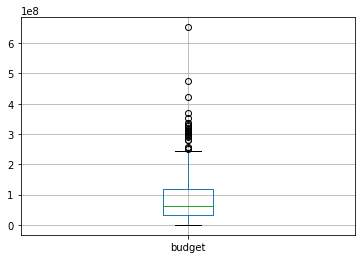

In [198]:
movies_ratings.boxplot(column=['budget'])

### Variable: Metascore


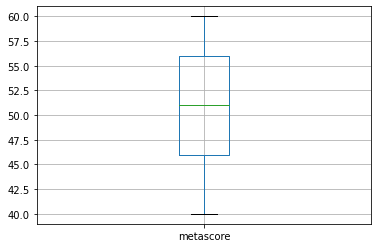

In [199]:
movies_ratings.boxplot(column=['metascore'])

### Variable: Popularity

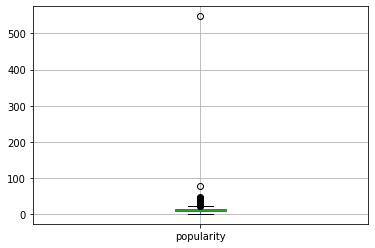

In [200]:
movies_ratings.boxplot(column=['popularity'])

In [201]:
# Removing outliers
movies_ratings = movies_ratings[movies_ratings.popularity < 300]

### Variable: Revenue

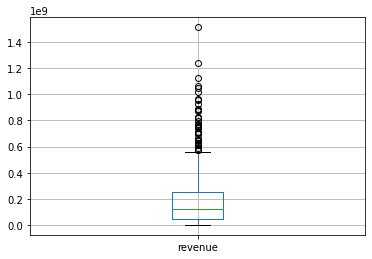

In [202]:
movies_ratings.boxplot(column=['revenue'])

## Plot 3: Ratings vs Metascore

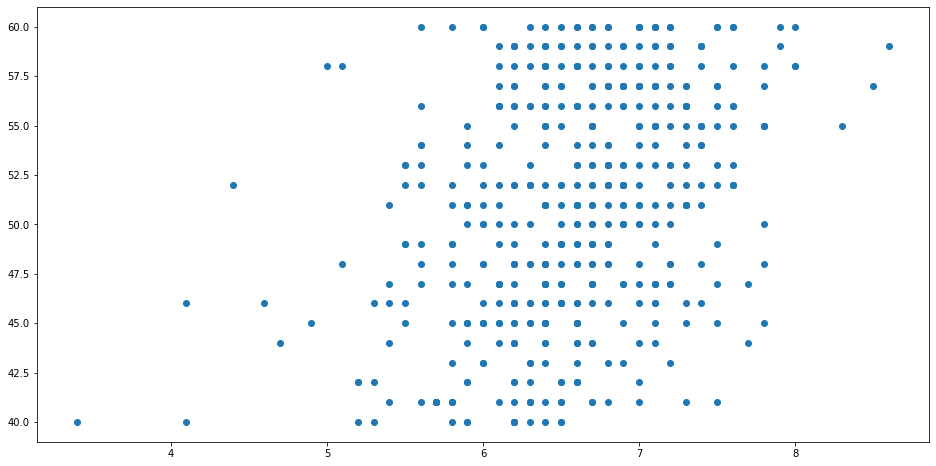

In [203]:
fig, ax = plt.subplots(1, figsize=(16,8))
ax.scatter('rating', 'metascore', data=movies_ratings)

## Plot 4: Revenue vs Budget

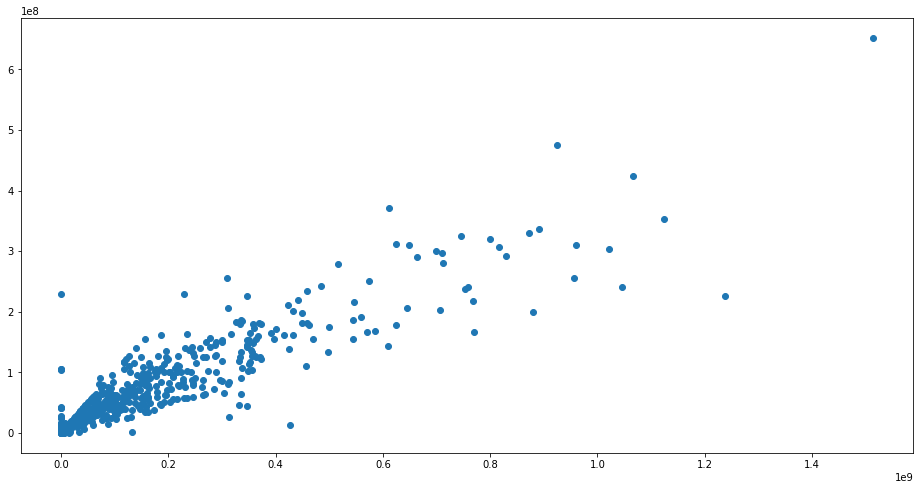

In [204]:
fig, ax = plt.subplots(1, figsize=(16,8))
ax.scatter('revenue', 'budget', data=movies_ratings)

## Plot 5: Distribution of Ratings

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Ratings')

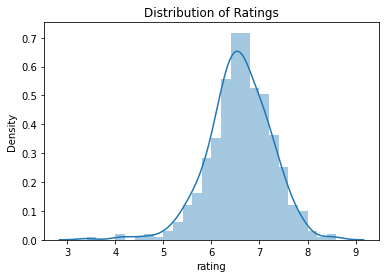

In [205]:
sns.distplot(movies_ratings['rating']).set_title('Distribution of Ratings')

## Plot 6: Distribution of Metascore

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Metascore')

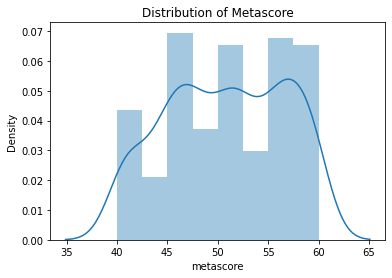

In [206]:
sns.distplot(movies_ratings['metascore']).set_title('Distribution of Metascore')

## Plot 7: Distribution of Duration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Duration')

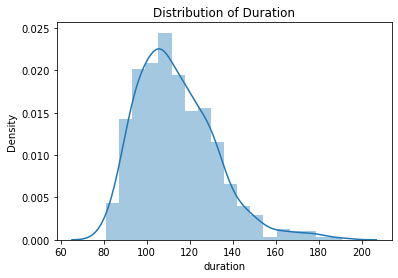

In [207]:
sns.distplot(movies_ratings['duration']).set_title('Distribution of Duration')

## Plot 8: Distribution of Budget

Text(0.5, 1.0, 'Distribution of Budget')

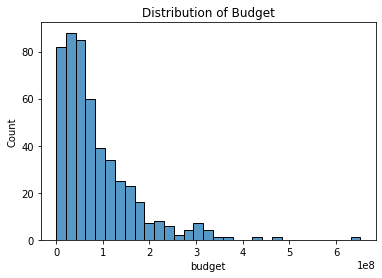

In [208]:
sns.histplot(movies_ratings['budget']).set_title('Distribution of Budget')

## Plot 9: Distribution of Revenue

Text(0.5, 1.0, 'Distribution of Revenue')

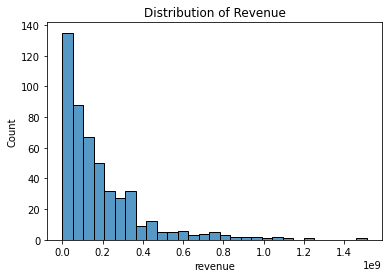

In [209]:
sns.histplot(movies_ratings['revenue']).set_title('Distribution of Revenue')

## Plot 10: Scatter Plot of Popularity and Budget

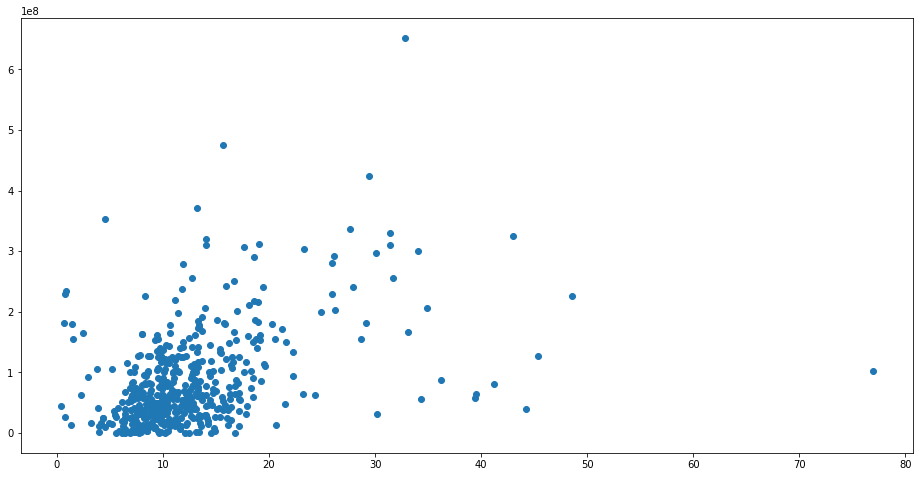

In [210]:
fig, ax=plt.subplots(1, figsize=(16,8))
ax.scatter('popularity', 'budget', data=movies_ratings)

## Plot 11: Scatter Plot of Popularity and Revenue

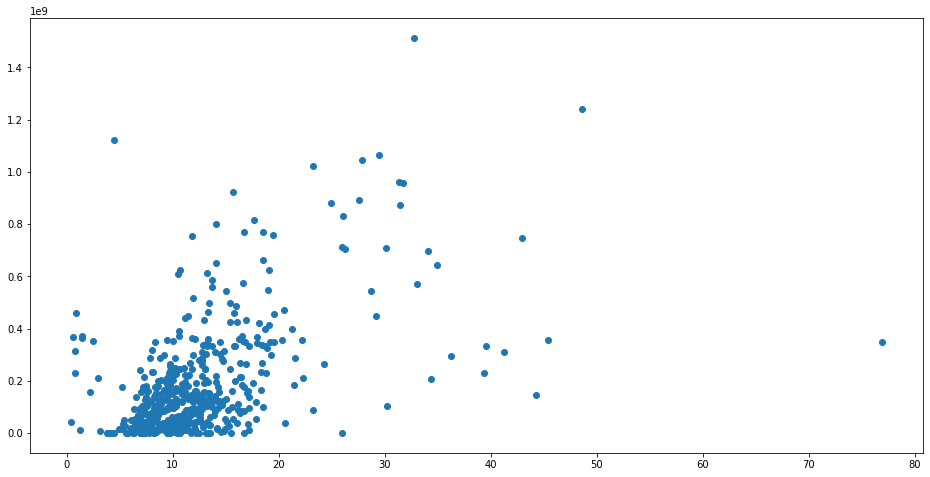

In [211]:
fig, ax=plt.subplots(1, figsize=(16,8))
ax.scatter('popularity', 'revenue', data=movies_ratings)

## Plot 12: Original Language, rating and metascore

<BarContainer object of 18 artists>

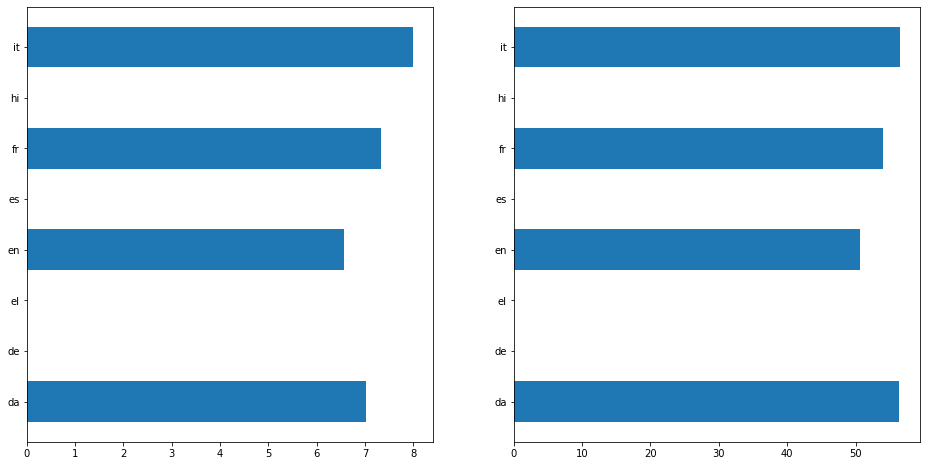

In [212]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].barh('original_language', 'rating', data=movies_ratings.groupby('original_language', as_index=False).mean())
ax[1].barh('original_language', 'metascore', data=movies_ratings.groupby('original_language', as_index=False).mean())

## Table 1: Details for each year

In [213]:
movies_ratings.groupby('year', as_index=False).mean()

,year,duration,rating,budget,metascore,popularity,revenue
0,1939,NaN,NaN,NaN,NaN,NaN,NaN
1,1941,NaN,NaN,NaN,NaN,NaN,NaN
2,1942,NaN,NaN,NaN,NaN,NaN,NaN
3,1945,NaN,NaN,NaN,NaN,NaN,NaN
4,1946,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
69,2013,113.000000,6.614815,6.708556e+07,49.407407,12.377853,1.424225e+08
70,2014,115.400000,6.560000,8.654200e+07,49.050000,19.798173,2.480037e+08
71,2015,121.800000,6.333333,1.115593e+08,50.533333,19.967811,3.175682e+08
72,2016,114.583333,6.404167,8.897542e+07,50.375000,19.628172,2.540122e+08


## Table 2: Details for each Language

In [214]:
movies_ratings.groupby('original_language', as_index=False).mean()

,original_language,duration,rating,budget,metascore,popularity,revenue
0,ca,NaN,NaN,NaN,NaN,NaN,NaN
1,cn,NaN,NaN,NaN,NaN,NaN,NaN
2,da,136.666667,7.033333,7.533333e+05,56.333333,9.057453,6.566623e+06
3,de,NaN,NaN,NaN,NaN,NaN,NaN
4,el,NaN,NaN,NaN,NaN,NaN,NaN
5,en,113.549383,6.562551,8.618990e+07,50.695473,12.595289,1.935465e+08
6,es,NaN,NaN,NaN,NaN,NaN,NaN
7,fr,112.500000,7.325000,1.367250e+07,54.000000,11.372039,1.155844e+08
8,hi,NaN,NaN,NaN,NaN,NaN,NaN
9,it,112.000000,8.000000,3.052500e+07,56.500000,24.442741,1.147000e+08


# Modeling

In [215]:
# Encoding year and original_language

c = movies_ratings[['year', 'original_language']]
encoder = OneHotEncoder(sparse=False)
encoder.fit(c)
c2 = encoder.transform(c)
df = pd.DataFrame(c2, columns=encoder.get_feature_names())
df
movies_ratings2 = pd.concat([movies_ratings.drop(['year', 'original_language'], axis = 1), df], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [216]:
# Dropping variables which will not be used

movies_ratings=movies_ratings2.drop(['title', 'description', 'director', 'actors', 'votes', 'adult', 'genres',
                                     'poster_path', 'production_companies', 'production_countries'], axis=1)

In [217]:
# Dropping null values

movies_ratings=movies_ratings.dropna(how='any', axis=0)

In [218]:
# Splitting the data into train and test data

y = movies_ratings.rating
x = movies_ratings.drop('rating', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

## Linear Regression

In [219]:
regressor = LinearRegression()

# Training the algorithm

regressor.fit(x_train, y_train)

LinearRegression()

In [220]:
# Coefficients

coeff_df = pd.DataFrame(regressor.coef_, x.columns, columns = ['Coefficient'])
coeff_df

,Coefficient
duration,1.255905e-02
budget,-2.124966e-09
metascore,3.425627e-02
popularity,1.076187e-03
revenue,1.224920e-10
x0_1970,-1.378367e-08
x0_1971,-1.339069e-08
x0_1972,1.675330e-08
x0_1973,6.928744e-09
x0_1976,-2.573303e-09


In [221]:
# Prediction

y_pred = regressor.predict(x_test)

In [222]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(20)
df1

,Actual,Predicted
30,7.8,7.517834
422,7.6,6.834480
138,7.6,7.503000
110,6.2,6.891991
267,7.1,6.662149
416,6.7,6.202122
293,6.2,7.090553
410,6.0,5.883419
443,8.0,6.679767
275,7.4,6.563925


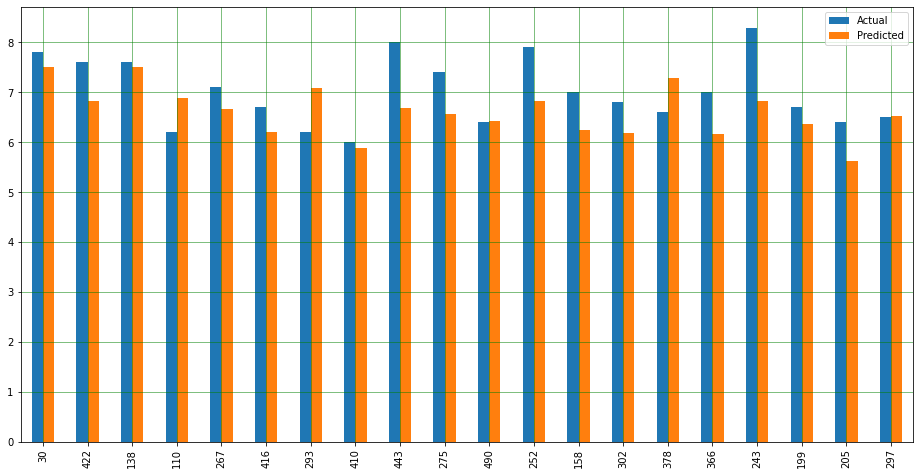

In [223]:
df1.plot(kind='bar', figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='black')
plt.show()

In [224]:
# Metrics

print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error:  0.6332923587389645
Mean Squared Error:  0.558183435566351
Root Mean Squared Error:  0.7471167482839285


## Regression Tree

In [225]:
regr_2 = DecisionTreeRegressor(max_depth=5)
reg_tree=regr_2.fit(x_train, y_train)

In [226]:
# Predict
y_2 = regr_2.predict(x_test)
y_2

array([7.1125    , 7.1125    , 7.1125    , 7.1125    , 6.8962963 ,
       6.2       , 6.8962963 , 6.5       , 7.1125    , 7.1125    ,
       7.1125    , 7.1125    , 6.1       , 6.8962963 , 6.8962963 ,
       7.1125    , 7.1125    , 7.1125    , 6.8962963 , 6.57142857,
       6.8       , 6.5       , 6.9       , 6.57142857, 7.1125    ,
       6.18      , 7.1125    , 7.1125    , 6.8962963 ])

In [227]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_2})
df3 = df.head(20)
df3

,Actual,Predicted
30,7.8,7.517834
422,7.6,6.834480
138,7.6,7.503000
110,6.2,6.891991
267,7.1,6.662149
416,6.7,6.202122
293,6.2,7.090553
410,6.0,5.883419
443,8.0,6.679767
275,7.4,6.563925


In [228]:
# Metrics

print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_2))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_2))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_2)))

Mean Absolute Error:  0.5105327494982669
Mean Squared Error:  0.370831630082855
Root Mean Squared Error:  0.6089594650572853


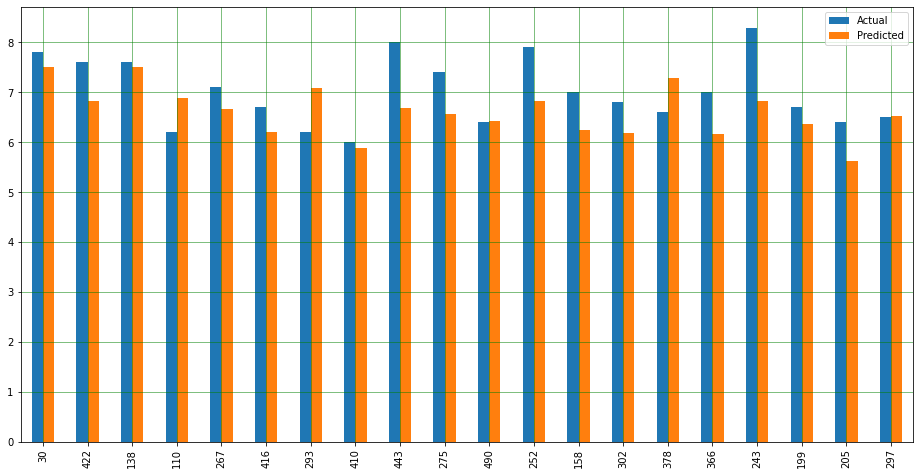

In [229]:
df3.plot(kind='bar', figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='black')
plt.show()

## Random Forest

In [230]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

predicted_ratings = model.predict(x_test)

In [231]:
df7 = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_ratings})
df8 = df3.head(20)
df8

,Actual,Predicted
30,7.8,7.517834
422,7.6,6.834480
138,7.6,7.503000
110,6.2,6.891991
267,7.1,6.662149
416,6.7,6.202122
293,6.2,7.090553
410,6.0,5.883419
443,8.0,6.679767
275,7.4,6.563925


In [232]:
# Metrics

print('Mean Absolute Error: ', metrics.mean_absolute_error(y_test, predicted_ratings))
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, predicted_ratings))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, predicted_ratings)))

Mean Absolute Error:  0.48041379310344784
Mean Squared Error:  0.35429310344827447
Root Mean Squared Error:  0.5952252543770925


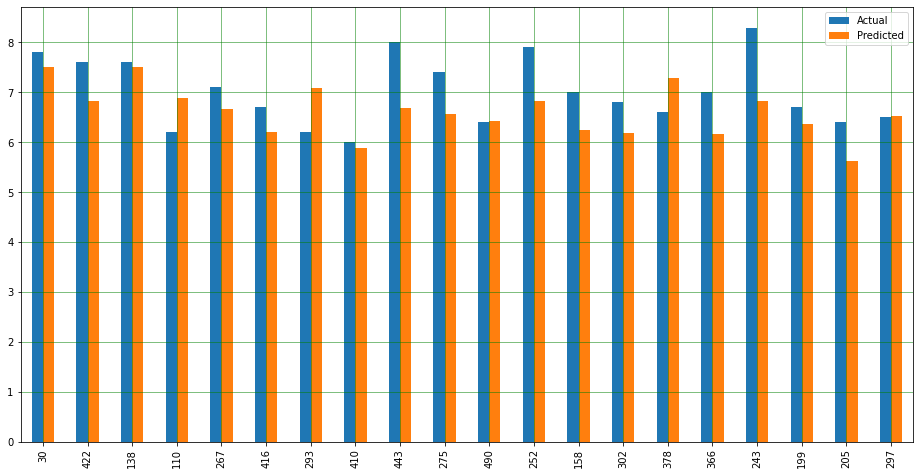

In [233]:
df8.plot(kind='bar', figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='black')
plt.show()

# Conclusion

After observing the Mean Squared Error (MSE) for all the models, I have come to a conclusion that, Random Forest is the best model with MSE value of ***0.2434*** followed by Regression Tree with MSE value of ***0.3526*** followed by Linear Regression with MSE value of ***0.50841***.

**MSE values:**

1. **Random Forest**: 0.2434
2. **Regression Tree**: 0.3526
3. **Linear Regression**: 0.50841